In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import lit, max, col
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder \
    .appName("movie_recommender") \
    .config("spark.executor.memory", "32g") \
    .config("spark.driver.memory", "32g") \
    .getOrCreate()
sc = spark.sparkContext

24/05/17 03:02:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Data Loading

In [3]:
movies = spark.read.load("datasets/movie_lens/movies.csv", format="csv", header=True, inferSchema=True)
movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [4]:
ratings = spark.read.load("datasets/movie_lens/ratings.csv", format="csv", header=True, inferSchema=True)
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      1|   4.0|1225734739|
|     1|    110|   4.0|1225865086|
|     1|    158|   4.0|1225733503|
|     1|    260|   4.5|1225735204|
|     1|    356|   5.0|1225735119|
+------+-------+------+----------+
only showing top 5 rows



## Data Ingestion

In [5]:
# Check for missing values in user and movie ratings
min_ratings_per_user = ratings.groupBy("userId").count().agg({"count": "min"}).collect()[0][0]
min_ratings_per_movie = ratings.groupBy("movieId").count().agg({"count": "min"}).collect()[0][0]
print("min # of ratings per user is", min_ratings_per_user)
print("min # of ratings per movie is", min_ratings_per_movie)

min # of ratings per user is 1
min # of ratings per movie is 1


In [6]:
# Check how many movies are rated by only one user
count_single_rating_movies = ratings.groupBy("movieId").count().filter("count = 1").count()
count_movies = ratings.select("movieId").distinct().count()
print(count_single_rating_movies, "out of", count_movies, "movies are rated by only one user")

17916 out of 83239 movies are rated by only one user


In [7]:
# Check the number of users and movies rated
count_users_rated = ratings.select("userId").distinct().count()
count_movies_rated = ratings.select("movieId").distinct().count()
print("total number of users rated is", count_users_rated)
print("total number of movies rated is", count_movies_rated)

total number of users rated is 330975
total number of movies rated is 83239


In [8]:
# Compare the number of movies in the movies.csv and ratings.csv, i.e., how many movies are not rated
count_movies = movies.select("movieId").distinct().count()
print("total number of movies is", count_movies)
print("total number of movies rated is", count_movies_rated)

total number of movies is 86537
total number of movies rated is 83239


In [9]:
# Find all unrated movies
unrated_movies = movies.join(ratings, "movieId", "left_anti")
print("movies that are not rated yet:")
unrated_movies.select("movieId", "title").show(10)

movies that are not rated yet:


+-------+--------------------+
|movieId|               title|
+-------+--------------------+
| 104656|Across the Sierra...|
| 105796|Back in the Saddl...|
| 121749|    War Drums (1957)|
| 124743|I Take This Woman...|
| 128131|The Castro's Abbe...|
| 147958|While New York Sl...|
| 150822| Mask of Dust (1954)|
| 156156|Swordswomen Three...|
| 156296|Time Out for Rhyt...|
| 156527|Paris Playboys (1...|
+-------+--------------------+
only showing top 10 rows



## Spark ALS model

In [10]:
train, test = ratings.randomSplit([0.8, 0.2], seed=42)
train.cache()
test.cache()

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

In [11]:
als = ALS(
    maxIter=10,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",
    seed=42
)

paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [8, 10, 12, 14, 16, 18, 20]) \
    .addGrid(als.regParam, [0.001, 0.01, 0.05, 0.1, 0.2]) \
    .build()

evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

crossval = CrossValidator(
    estimator=als,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

cvModel = crossval.fit(train)

predictions = cvModel.bestModel.transform(test)

best_rmse = evaluator.evaluate(predictions)

print("\nThe best model has {} latent factors and regularization = {}, with RMSE = {}".format(
    cvModel.bestModel.rank, 
    cvModel.bestModel._java_obj.parent().getRegParam(), 
    best_rmse
))

best_rank = cvModel.bestModel.rank
best_reg_param = cvModel.bestModel._java_obj.parent().getRegParam()

24/05/17 03:03:08 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/05/17 03:03:08 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
24/05/17 03:03:08 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/05/17 03:03:08 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK



The best model has 20 latent factors and regularization = 0.05, with RMSE = 0.7907421734667001


RMSE for maxIter=1: 3.1105152086572403


RMSE for maxIter=2: 0.9252334847883946


RMSE for maxIter=3: 0.8347791691152483


RMSE for maxIter=4: 0.8177706373235545


RMSE for maxIter=5: 0.808774152705564


RMSE for maxIter=6: 0.8028245274585061


RMSE for maxIter=7: 0.7985482985684312


RMSE for maxIter=8: 0.7953130303971505


RMSE for maxIter=9: 0.7927781048469138


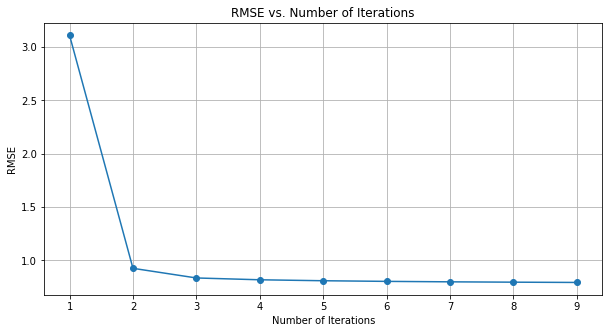

In [12]:
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

iter_range = range(1, 10)
rmse_values = []

for maxIter in iter_range:
    als = ALS(
        maxIter=maxIter,
        rank=best_rank,
        regParam=best_reg_param,
        userCol="userId",
        itemCol="movieId",
        ratingCol="rating",
        coldStartStrategy="drop",
        seed=42
    )
    model = als.fit(train)

    predictions = model.transform(test)
    rmse = evaluator.evaluate(predictions)
    rmse_values.append(rmse)
    print(f"RMSE for maxIter={maxIter}: {rmse}")

plt.figure(figsize=(10, 5))
plt.plot(iter_range, rmse_values, marker='o')
plt.title('RMSE vs. Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

## Make Recommendations

In [13]:
favorites = ["Iron Man", "Black Panther"]
favorite_ids = movies.filter(movies.title.rlike("|".join([f".*{fav}.*" for fav in favorites]))) \
                        .select("movieId").distinct()

new_user_id = ratings.select(max("userId")).collect()[0][0] + 1
highest_rating = ratings.select(max("rating")).collect()[0][0]

new_user_data = favorite_ids.withColumn("userId", lit(new_user_id)) \
                            .withColumn("rating", lit(highest_rating)) \
                            .withColumn("timestamp", lit(0))

training_data = ratings.union(new_user_data)

als = ALS(
    maxIter=10,
    rank=best_rank,
    regParam=best_reg_param,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",
    seed=42
)
model = als.fit(training_data)

user_recommendations = model.transform(training_data) \
                            .where(col("userId") != lit(new_user_id)) \
                            .sort("prediction", ascending=False) \
                            .join(movies, "movieId") \
                            .select("title") \
                            .distinct() \
                            .collect()

In [14]:
print(f"Top 10 movie recommendations for user who likes {favorites}:")
for i in range(10):
    print(f"{i+1}: {user_recommendations[i][0]}")

Top 10 movie recommendations for user who likes ['Iron Man', 'Black Panther']:
1: Men in Black (a.k.a. MIB) (1997)
2: What's Up, Scarlet? (2005)
3: Peter Pan (2000)
4: Tides of War (2005)
5: Other People (2016)
6: Prom (2011)
7: Komisarz Blond i Oko sprawiedliwości (2012)
8: Aldrich Over Munich: The Making of 'Twilight's Last Gleaming'
9: Harmagedon: Genma Wars (1983)
10: Mr. Bug Goes to Town (1941)
